### DeepPong: A Deep Learning Approach to Real-time Frame Generation for Pong

This notebook walks through training different neural networks to assess their ability to generate computer graphics in real-time. For this project, our scope was limited to the simple game of [Pong](https://en.wikipedia.org/wiki/Pong).

This project requires [pygame](https://github.com/pygame/pygame) to run.

In [1]:
%pip install pygame

#### Creating the Models and Generating the Dataset


We start off by importing a simple implementation of Pong and some defined constants.

In [2]:
from pong import *

pygame 2.6.1 (SDL 2.28.4, Python 3.11.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


Then we define a function to generate the dataset. Because generating each game state and capturing the screen is relatively cheap (due to the resolution), we can generate a large amount of data both quickly and deterministically.

In [3]:
import os
import pandas as pd
import tensorflow as tf


def generate_dataset(score_combinations=SCORE_COMBINATIONS, states_per_score=STATES_PER_SCORE, timesteps=TIMESTEPS, save_to_disk=False, seed=RANDOM_SEED):
    '''Generates a dataset of frames and states from Pong.'''

    pong = Pong(sound_enabled=False)
    df = pd.DataFrame(columns=['left_x', 'left_y', 'right_x', 'right_y', 'ball_x', 'ball_y', 'ball_vx', 'ball_vy', 'left_score', 'right_score'])
    screenshots = []
    i = 0

    # Make sure the image directory exists.
    if save_to_disk:
        os.makedirs(DATA_DIRECTORY_NAME, exist_ok=True)

    # Ensures reproducibility.
    random.seed(seed)

    for p1_score, p2_score in score_combinations:
        for state in range(states_per_score):
            pong.restart()  # Start a new phase of the game.

            # Generate a random state.
            pong.p1.y = random.uniform(PADDLE_HEIGHT, SCREEN_HEIGHT)
            pong.p1.score = p1_score

            pong.p2.y = random.uniform(PADDLE_HEIGHT, SCREEN_HEIGHT)
            pong.p2.score = p2_score

            pong.ball.x = random.uniform(GOAL_PADDING, SCREEN_WIDTH - GOAL_PADDING)
            pong.ball.y = random.uniform(BALL_SIZE, SCREEN_HEIGHT)

            overrides = {}
            pong.paused = False

            # Simulate the game for a couple timesteps.
            for _ in range(timesteps):
                pong.update(IDEAL_DT, overrides)
                state, screenshot = pong.capture()

                if save_to_disk:
                    pygame.image.save(screenshot, f'{DATA_DIRECTORY_NAME}/{i}.png')

                # Create a new record.
                df.loc[len(df)] = state
                screenshot = pygame.surfarray.array3d(screenshot).astype(np.uint8)
                screenshot = np.transpose(screenshot, (1, 0, 2))  # (height, width, 3)
                screenshot = screenshot[..., 0] / 255.0 # or 1 or 2, since R = G = B
                screenshot = screenshot.reshape(-1)
                screenshots.append(screenshot)

                # Simulate player input that simply chases the ball.
                overrides = {}

                for paddle in pong.paddles:
                    if pong.ball.y >= paddle.y :  # Ball is above the paddle, move up.
                        overrides[paddle.up] = True
                    elif pong.ball.y - BALL_SIZE <= paddle.y - PADDLE_HEIGHT:  # Ball is below the paddle, move down
                        overrides[paddle.down] = True

                i += 1

    if save_to_disk:
        df.to_csv(SPREADSHEET_FILEPATH, index=False)

    # Convert to numpy arrays.
    states = df.to_numpy()
    screenshots = np.stack(screenshots)

    return states, screenshots

You can also load in a previously generated dataset if it was previously saved to disk as well (although it might be faster just to generate it on the fly again).

In [4]:
def load_dataset():
    '''Loads in a previously generated dataset from disk.'''

    # Read in the state data.
    df = pd.read_csv(SPREADSHEET_FILEPATH)

    # Load in all the screenshots.
    screenshots = []

    for i, _ in df.iterrows():
        path = f'{DATA_DIRECTORY_NAME}/{i}.png'
        screenshot = tf.io.read_file(path)
        screenshot = tf.image.decode_png(screenshot, channels=1).numpy() / 255
        screenshot = tf.squeeze(screenshot, axis=-1)
        screenshot = tf.reshape(screenshot, [-1])
        screenshots.append(screenshot)

    # Convert to numpy arrays.
    states = df.to_numpy()
    screenshots = np.stack(screenshots)

    return states, screenshots

Here is some code for generating the different types of hyperparameters to test.

In [5]:
from itertools import product


def generate_configs(options):
    '''Generates the Cartesian product of the supplied dictionary.'''

    keys = options.keys()
    values = options.values()
    return [dict(zip(keys, combo)) for combo in product(*values)]


def stringify(config):
    '''Converts a model config to a single string based its values.'''

    return '_'.join([str(option).replace(' ','') for option in config.values()])

And here is the accompanying code to generate each model architecture based on the list all the different hyperparameter combinations.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten


PIXELS = SCREEN_WIDTH * SCREEN_HEIGHT


def generate_fcnn_models(options):
    '''Generates a list of compiled feed-forward neural networks.'''

    models = []

    for config in generate_configs(options):
        layers = []

        # Add the hidden layers.
        for neurons in config['neurons']:
            layers.append(Dense(neurons, activation=config['activation']))

        # Add the output layer.
        layers.append(Dense(PIXELS, activation='sigmoid'))

        model = Sequential(layers)
        model.compile(optimizer=config['optimizer'], loss='binary_crossentropy')
        name = 'dense_' + stringify(config)

        models.append((model, name))

    return models


def generate_rnn_models(options):
    '''Generates a list of compiled recurrent neural networks.'''

    models = []

    for config in generate_configs(options):
        layers = []

        # LSTM layers.
        for i, neurons in enumerate(config['bottom_layers'], 1):
            return_sequences = i != len(config['bottom_layers'])
            layers.append(LSTM(neurons, activation='tanh', dropout=config['dropout'], return_sequences=return_sequences))

        # Decoder layers.
        for neurons in config['top_layers']:
            layers.append(Dense(neurons, activation='relu'))

        # Output layer.
        layers.append(Dense(PIXELS, activation='sigmoid'))

        model = Sequential(layers)
        model.compile(optimizer=config['optimizer'], loss='binary_crossentropy')
        name = 'rnn__' + stringify(config)

        models.append((model, name))

    return models


def generate_cnn_models(options):
    '''Generates a list of compiled convolutional neural networks.'''

    models = []

    for config in generate_configs(options):
        layers = []

        # Convolutional and pooling layers.
        for neurons in config['bottom_layers']:
            layers.append(Conv2D(neurons, config['kernel_size'], activation='relu', padding='same'))
            layers.append(MaxPooling2D(config['pool_size'], padding='same'))

        # Output must be flattened.
        layers.append(Flatten())

        # Decoder.
        for neurons in config['top_layers']:
            layers.append(Dense(neurons, activation='relu'))

        # Output layer.
        layers.append(Dense(PIXELS, activation='sigmoid'))

        model = Sequential(layers)
        model.compile(optimizer='adamw', loss='binary_crossentropy')
        name = 'cnn__' + stringify(config)

        models.append((model, name))

    return models

Up next is the main training function. Both `ModelCheckpoint` and `EarlyStopping` are used to prevent overfitting and increase performance.

In [7]:
import time

from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm


@dataclass
class Result:
    '''A small struct-like class for recording a model's performance.'''

    name: str
    score: float
    latency: float


def train(models, X_train, y_train, X_test, y_test):
    '''Trains a set of models on the supplied data.'''

    results = []

    for model, name in tqdm(models, desc='Training Models'):
        training_filepath = f'{TRAINING_DIRECTORY_NAME}/{name}.keras'

        # Callbacks to help increase model performance.
        checkpointer = ModelCheckpoint(filepath=training_filepath, verbose=0, save_best_only=True)
        stopper = EarlyStopping(patience=5, verbose=0, min_delta=1e-3)

        # Train the model.
        model.fit(X_train, y_train, epochs=1000, verbose=0, validation_data=(X_test, y_test), callbacks=[checkpointer, stopper])

        # Swap to the best version for evaluation.
        model.load_weights(training_filepath)

        # Evaluate the model's performance.
        predictions = model.predict(X_test, verbose=0)
        predictions = np.round(predictions)
        score = metrics.f1_score(predictions, y_test, average="weighted", zero_division=0)

        # Measure the model's latency.
        start = time.time()

        for i in range(10):
            _ = model.predict(X_train[i:i+1], verbose=0)

        latency = (time.time() - start) / 10

        results.append(Result(name, score, latency))

    return results

Here are some utilities for showcasing the best models' performance in a neat table as well as saving them for using in the final application later.

In [8]:
import shutil
import matplotlib.pyplot as plt


column_titles = f'| {"Model Rank":^12} | {"Model Name":^36} | {"F1-Score":^14} | {"Latency":^11} |'
separator = '=' * len(column_titles)


def select_best_and_worst_results(results, metric, best_filepath):
    '''Returns the best and worst models/results based on the given metric (score or latency).'''

    results.sort(key=metric)
    best_result = results[0]
    worst_result = results[-1]

    # Save the best model.
    shutil.copy2(f'{TRAINING_DIRECTORY_NAME}/{best_result.name}.keras', best_filepath)

    return best_result, worst_result


def print_header(title):
    '''Prints a formatted header for displaying results.'''

    title = f'|{title.center(len(separator) - 2)}|'

    for section in [separator, title, separator, separator, separator]:
        print(section)


def print_top_results(title, results, count):
    '''Prints the results of the top models.'''

    print_header(title)

    for i, result in enumerate(results[:count]):
        # Names that are too long must be truncated with '...'.
        name = result.name[:33] + '...' if len(result.name) > 22 else result.name
        print(f'| {i + 1:^12} | {name:^36} | {result.score:^14.5f} | {result.latency:^11.5f} |')


def show_reports(model_filepath, X_test, y_test, title):
    '''Shows the confusion matrix, classification report, and ROC for the given model.'''

    model = keras.models.load_model(model_filepath)

    # Make the predictions.
    predictions = model.predict(X_test, verbose=0)
    predictions = np.round(predictions)

    # But only for a single frame. There is no need to do all of them because its around the same performance.
    prediction, truth = predictions[0], y_test[0]

    # Plot the confusion matrix (for a single frame).
    print('')
    print(separator)
    cm_title = title + ' Confusion Matrix'
    print(f'|{cm_title.center(len(separator) - 2)}|')
    print(separator)
    print('')

    cm = metrics.confusion_matrix(truth, prediction)
    cmd = metrics.ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.show()

    # Show the classification report.
    print('')
    print(separator)
    cr_title = title + ' Classification Report'
    print(f'|{cr_title.center(len(separator) - 2)}|')
    print(separator)

    print('')
    cr = metrics.classification_report(truth, prediction, zero_division=0)
    print(cr)

    # Plot the ROC curve.
    fpr, tpr, thresholds = metrics.roc_curve(truth, prediction)
    roc_auc = metrics.auc(fpr, tpr)

    print('')
    print(separator)
    cr_title = title + ' Receiver Operating Characteristic (ROC)'
    print(f'|{cr_title.center(len(separator) - 2)}|')
    print(separator)

    print('')
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    print('')


def evaluate(results, X_test, y_test, best_model_filepaths, count=5):
    '''Shows the best scoring and fastest latency results in a table.'''

    os.makedirs(BEST_MODEL_DIRECTORY_PATH, exist_ok=True)

    # Print best results by score.
    score_metric = lambda result: -result.score
    best_score_result, worst_score_result = select_best_and_worst_results(results, score_metric, best_model_filepaths[0])

    print_top_results('Best F1-Score', results, count)
    print(f'| {"-":^12} | {"F1-SCORE RANGE":^36} | {worst_score_result.score:^14.5f} | {best_score_result.score:^11.5f} |')

    # Print best results by latency.
    latency_metric = lambda result: result.latency
    best_latency_result, worst_latency_result = select_best_and_worst_results(results, latency_metric, best_model_filepaths[1])

    print_top_results('Best Latency ', results, count)
    print(f'| {"-":^12} | {"LATENCY RANGE":^36} | {best_latency_result.latency:^14.5f} | {worst_latency_result.latency:^11.5f} |')
    print(separator)

    show_reports(best_model_filepaths[0], X_test, y_test, 'Best F1-Score')
    show_reports(best_model_filepaths[1], X_test, y_test, 'Best Latency')

#### Training the Models

Now we can finally train some models! We start of by generating and splitting the dataset.

In [9]:
from sklearn.model_selection import train_test_split


X, y = generate_dataset()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape[0], X_test.shape[0], FEATURES, y_train.shape[1]

(19800, 4950, 10, 30720)

We will start off by training the FCNN first.

In [10]:
from sklearn.model_selection import train_test_split


fcnn_options = {
    'neurons': [[], [128], [128, 256], [128, 256, 512], [128, 256, 512, 1024]],
    'activation': [None, 'relu', 'tanh'],
    'optimizer': ['adam', 'adamw', 'sgd']
}

fcnn_models = generate_fcnn_models(fcnn_options)
results = train(fcnn_models, X_train, y_train, X_test, y_test)

Training Models: 100%|██████████| 45/45 [1:42:53<00:00, 137.18s/it]


After training is done, it's time to showcase the best results (based on weighted F1-score and latency).

|                                   Best F1-Score                                    |
|      1       |  dense_[128,256,512]_tanh_adamw...   |    0.99326     |   0.09769   |
|      2       |    dense_[128,256]_tanh_adamw...     |    0.99234     |   0.12407   |
|      3       |   dense_[128,256,512]_tanh_adam...   |    0.99207     |   0.22187   |
|      4       |  dense_[128,256,512]_relu_adamw...   |    0.99148     |   0.08960   |
|      5       | dense_[128,256,512,1024]_relu_ada... |    0.99066     |   0.10135   |
|      -       |            F1-SCORE RANGE            |    0.01266     |   0.99326   |
|                                   Best Latency                                     |
|      1       |          dense_[]_tanh_adam          |    0.91336     |   0.07179   |
|      2       |          dense_[]_tanh_sgd           |    0.01302     |   0.07214   |
|      3       |          dense_[]_relu_sgd           |    0.01266     |   0.07332   |
|      4       |        dense_[128]_None_ad

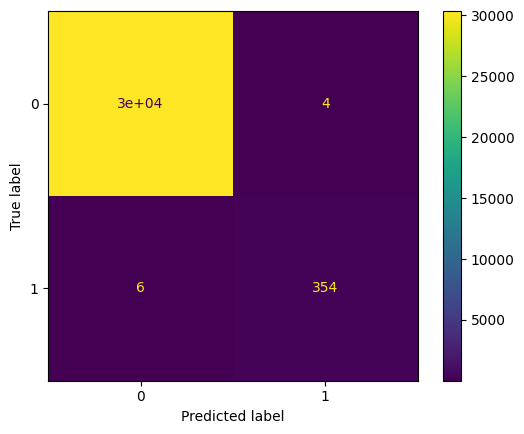


|                        Best F1-Score Classification Report                         |

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30360
         1.0       0.99      0.98      0.99       360

    accuracy                           1.00     30720
   macro avg       0.99      0.99      0.99     30720
weighted avg       1.00      1.00      1.00     30720


|               Best F1-Score Receiver Operating Characteristic (ROC)                |



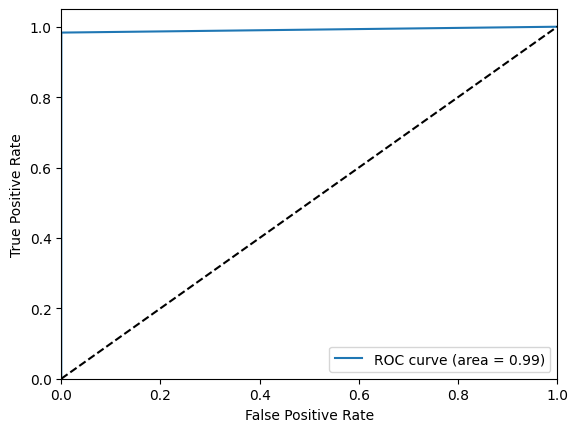



|                           Best Latency Confusion Matrix                            |



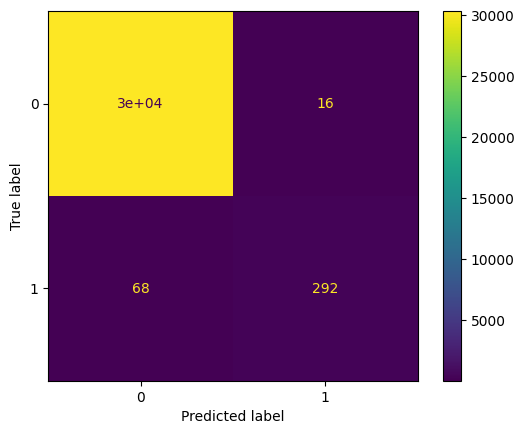


|                         Best Latency Classification Report                         |

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30360
         1.0       0.95      0.81      0.87       360

    accuracy                           1.00     30720
   macro avg       0.97      0.91      0.94     30720
weighted avg       1.00      1.00      1.00     30720


|                Best Latency Receiver Operating Characteristic (ROC)                |



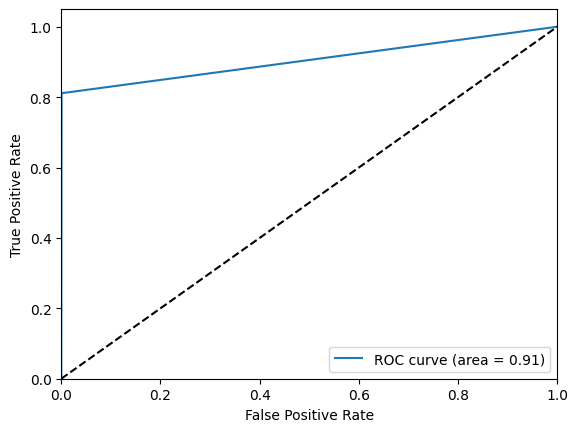

In [11]:
evaluate(results, X_test, y_test, FCNN_BEST_FILEPATHS)

Now that we're done with the FCNNs, next up are the RNNs. First, we need to reshape the dataset to be in the shape of `(samples, timesteps, features)`. Fortunately, this is easy to do because we generated the data by simulating games, so it was essentially a time serires to begin with.

In [12]:
# Reshape dataset as a time series.
X = X.reshape(SAMPLES // TIMESTEPS, TIMESTEPS, FEATURES)
y = y.reshape(SAMPLES // TIMESTEPS, TIMESTEPS, PIXELS)[:, -1, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape[0], X_test.shape[0]

(3960, 990)

Now we can train the RNNs.

In [13]:
rnn_options = {
    'bottom_layers': [[64], [64, 256], [128, 256, 512]],
    'top_layers': [[], [128, 512], [1024], [2048]],
    'dropout': [0.0, 0.1],
    'optimizer': ['adam', 'adamw', 'sgd']
}

rnn_models = generate_rnn_models(rnn_options)
results = train(rnn_models, X_train, y_train, X_test, y_test)

Training Models: 100%|██████████| 72/72 [28:15<00:00, 23.55s/it]


...and evaluate them as well.

|                                   Best F1-Score                                    |
|      1       |    rnn__[64]_[1024]_0.0_adamw...     |    0.90933     |   0.07066   |
|      2       |     rnn__[64,256]_[]_0.1_adam...     |    0.90879     |   0.06908   |
|      3       | rnn__[128,256,512]_[128,512]_0.0_... |    0.90160     |   0.07219   |
|      4       |     rnn__[64]_[1024]_0.1_adam...     |    0.90081     |   0.06818   |
|      5       |   rnn__[64]_[128,512]_0.1_adam...    |    0.90080     |   0.06886   |
|      -       |            F1-SCORE RANGE            |    0.01090     |   0.90933   |
|                                   Best Latency                                     |
|      1       |   rnn__[64,256]_[1024]_0.0_sgd...    |    0.01193     |   0.06643   |
|      2       | rnn__[128,256,512]_[2048]_0.0_ada... |    0.90046     |   0.06670   |
|      3       |   rnn__[64,256]_[2048]_0.1_adam...   |    0.90046     |   0.06714   |
|      4       |   rnn__[64,256]_[2048]_0.0

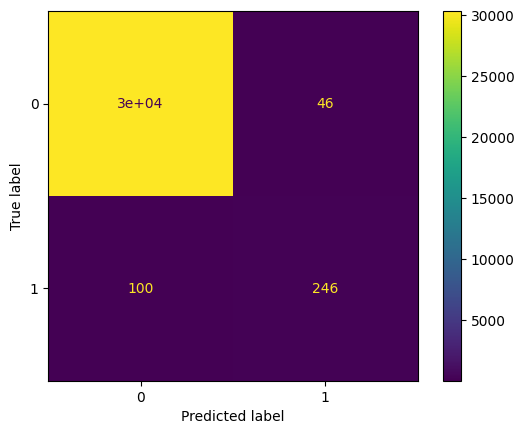


|                        Best F1-Score Classification Report                         |

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30374
         1.0       0.84      0.71      0.77       346

    accuracy                           1.00     30720
   macro avg       0.92      0.85      0.88     30720
weighted avg       0.99      1.00      1.00     30720


|               Best F1-Score Receiver Operating Characteristic (ROC)                |



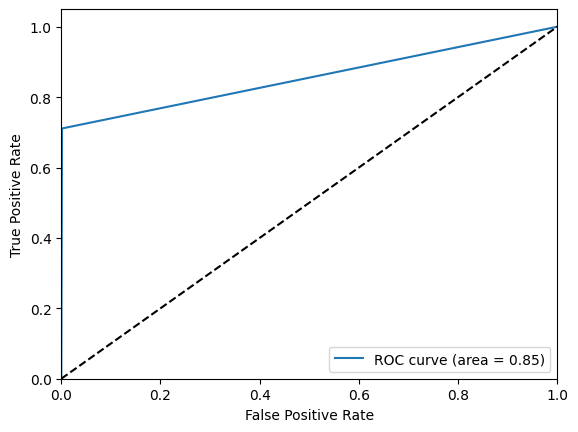



|                           Best Latency Confusion Matrix                            |



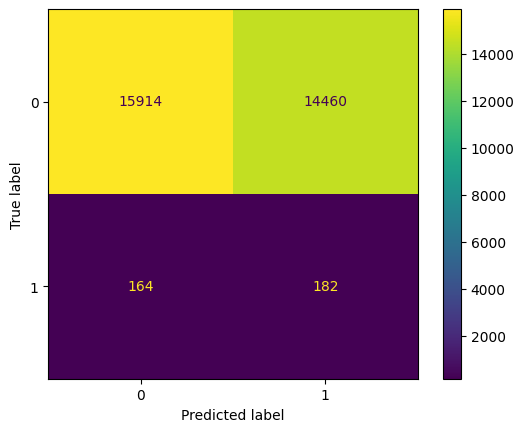


|                         Best Latency Classification Report                         |

              precision    recall  f1-score   support

         0.0       0.99      0.52      0.69     30374
         1.0       0.01      0.53      0.02       346

    accuracy                           0.52     30720
   macro avg       0.50      0.52      0.35     30720
weighted avg       0.98      0.52      0.68     30720


|                Best Latency Receiver Operating Characteristic (ROC)                |



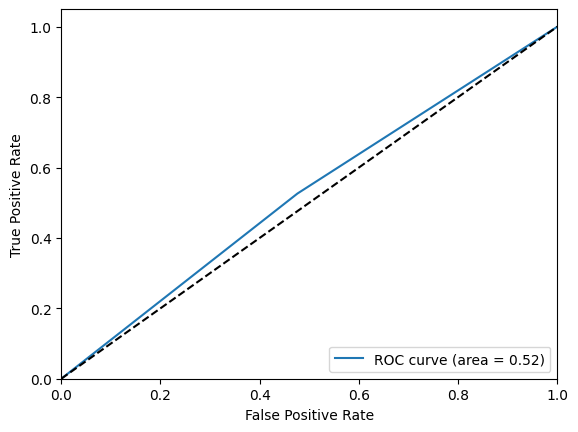

In [14]:
evaluate(results, X_test, y_test, RNN_BEST_FILEPATHS)

Last but not least are the CNNs. Just like the RNNs, we need to reshape the data. This time, we need to reshape them into `(samples, height, width, channels)`. To do this, we simply add another dimension to the end of the data so that the depth is `1`.

In [15]:
# Add depth.
X = np.expand_dims(X, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape

(3960, 5, 10, 1)

Now that the data has been shaped correctly, we can start training.

In [16]:
cnn_options = {
    'bottom_layers': [[32], [16, 32], [32, 64]],
    'top_layers': [[], [128, 256], [64, 128, 256], [512]],
    'pool_size': [(3, 3), (5, 5)],
    'kernel_size': [(2, 2), (3, 3)],
}

cnn_models = generate_cnn_models(cnn_options)
results = train(cnn_models, X_train, y_train, X_test, y_test)

Training Models: 100%|██████████| 48/48 [12:38<00:00, 15.81s/it]


Here are the best results:

|                                   Best F1-Score                                    |
|      1       |  cnn__[16,32]_[512]_(5,5)_(2,2)...   |    0.90909     |   0.09927   |
|      2       |    cnn__[32,64]_[]_(3,3)_(2,2)...    |    0.90619     |   0.08849   |
|      3       |     cnn__[32]_[]_(3,3)_(3,3)...      |    0.90529     |   0.08339   |
|      4       | cnn__[16,32]_[128,256]_(5,5)_(3,3... |    0.90500     |   0.08918   |
|      5       |     cnn__[32]_[]_(3,3)_(2,2)...      |    0.90498     |   0.08196   |
|      -       |            F1-SCORE RANGE            |    0.89073     |   0.90909   |
|                                   Best Latency                                     |
|      1       |     cnn__[32]_[]_(5,5)_(3,3)...      |    0.90139     |   0.07912   |
|      2       |     cnn__[32]_[]_(5,5)_(2,2)...      |    0.90131     |   0.07943   |
|      3       |    cnn__[16,32]_[]_(5,5)_(3,3)...    |    0.90046     |   0.08156   |
|      4       |     cnn__[32]_[]_(3,3)_(2,

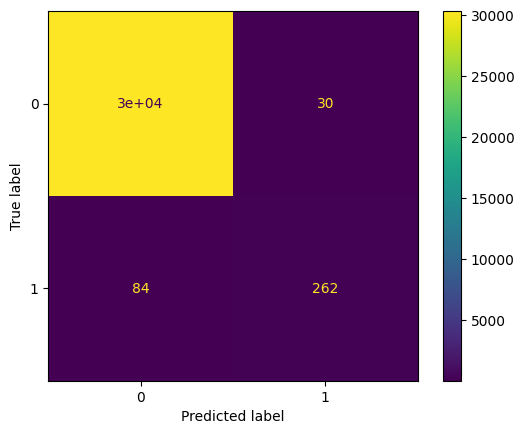


|                        Best F1-Score Classification Report                         |

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30374
         1.0       0.90      0.76      0.82       346

    accuracy                           1.00     30720
   macro avg       0.95      0.88      0.91     30720
weighted avg       1.00      1.00      1.00     30720


|               Best F1-Score Receiver Operating Characteristic (ROC)                |



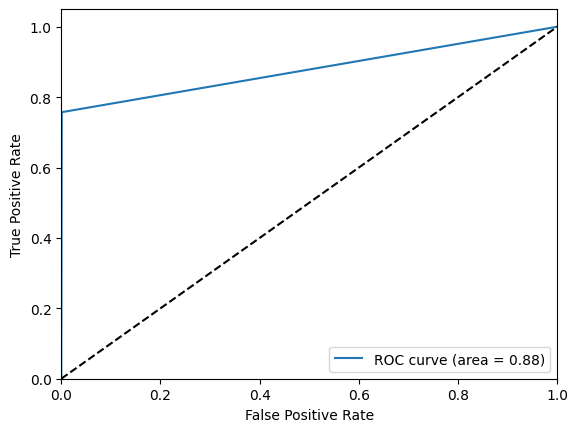



|                           Best Latency Confusion Matrix                            |



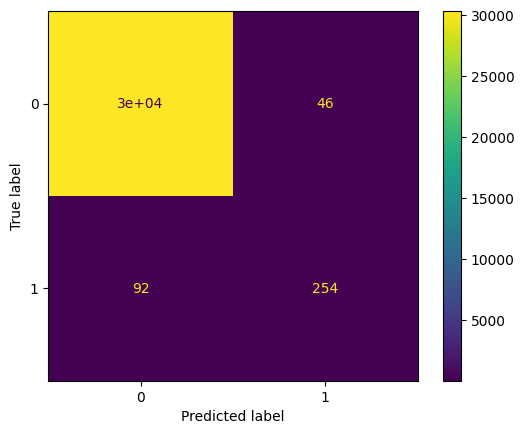


|                         Best Latency Classification Report                         |

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30374
         1.0       0.85      0.73      0.79       346

    accuracy                           1.00     30720
   macro avg       0.92      0.87      0.89     30720
weighted avg       1.00      1.00      1.00     30720


|                Best Latency Receiver Operating Characteristic (ROC)                |



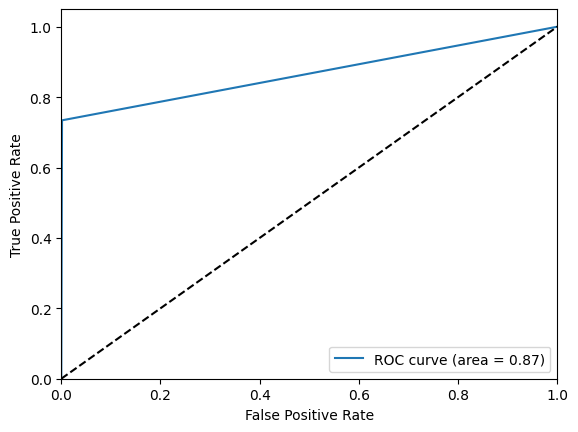

In [17]:
evaluate(results, X_test, y_test, CNN_BEST_FILEPATHS)

As a last-ditch attempt to squeeze the best performance out of our trained models, we now attempt to fine-tune the best-performing FCNN on a slightly different dataset with looser restrictions on the early stopping.

In [18]:
def finetune_fcnn(X_train, X_test, y_train, y_test, epochs=1000, patience=10, min_delta=0):
    '''Finetunes the best FCNN even further.'''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    model = keras.models.load_model(FCNN_BEST_FILEPATHS[0])
    training_filepath = f'{TRAINING_DIRECTORY_NAME}/{FCNN_FINETUNED_FILENAME}'

    checkpointer = ModelCheckpoint(filepath=training_filepath, verbose=0, save_best_only=True)
    stopper = EarlyStopping(patience=patience, verbose=0, min_delta=min_delta)

    # Train the model.
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test, y_test), callbacks=[checkpointer, stopper])

    # Swap to the best version for evaluation.
    model.load_weights(training_filepath)

    # Evaluate the model's performance.
    predictions = model.predict(X_test, verbose=0)
    predictions = np.round(predictions)
    score = metrics.f1_score(predictions, y_test, average="weighted", zero_division=0)

    model.save(FCNN_FINETUNED_FILEPATH)

    return score

We generate a new dataset and fine-tune the model.

In [19]:
# Generate a new, larger dataset. We don't need any timesteps because a FCNN won't benefit from the time series.
X, y = generate_dataset(states_per_score=325, timesteps=1)

print(f'Fine-tuning on {X.shape[0]} samples...')

# Fine-tune the previous best FCNN on this new dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
score = finetune_fcnn(X_train, X_test, y_train, y_test)

print(f'Final F1-score: {score:.5f}')

Fine-tuning on 32175 samples...
Final F1-score: 0.99461


In order to visualize our results, we define a function to generate side-by-side images of the actual frame and our predictions based on some random game states.

In [20]:
def generate_comparison_images(count, size=(12, 8), seed=RANDOM_SEED):
    '''Generates a side-by-side view of the different renderer outputs for a random game state.'''

    pong = create_pong()
    random.seed(seed)

    for i in range(count):
      # Generate random entity positions.
      pong.p1.y = random.uniform(PADDLE_HEIGHT, SCREEN_HEIGHT)
      pong.p2.y = random.uniform(PADDLE_HEIGHT, SCREEN_HEIGHT)
      pong.ball.x = random.uniform(GOAL_PADDING, SCREEN_WIDTH - GOAL_PADDING)
      pong.ball.y = random.uniform(BALL_SIZE, SCREEN_HEIGHT)

      # Set the score to a random (but valid) score.
      p1_score, p2_score = random.choice(SCORE_COMBINATIONS)
      pong.p1.score = p1_score
      pong.p2.score = p2_score

      # Update the game by one frame to ensure a valid game state.
      for j in range(TIMESTEPS):
          pong.update(IDEAL_DT)

      # Capture the output of each renderer.
      frames = []

      for renderer, title in enumerate(pong.renderer_names):
          _, screenshot = pong.capture(renderer=renderer)
          array = pygame.surfarray.array3d(screenshot)

          # Transpose the image to be the correct orientation.
          array = np.transpose(array, (1, 0, 2))

          frames.append((array, title))

      # Create a figure for the best scoring and best latency models separately.
      title = f'Comparison Image Set #{i + 1}'
      print(separator)
      print(f'|{title.center(len(separator) - 2)}|')
      print(separator)
      print('')

      for k in range(2):
          subset = frames[k::2]
          _, axes = plt.subplots(1, len(subset), figsize=size)

          for axis, (img, title) in zip(axes, subset):
              axis.imshow(img)
              axis.set_title(title)
              axis.axis("off")

          plt.tight_layout()
          plt.show()
          print('')

      print('')

Here are some examples:

|                              Comparison Image Set #1                               |



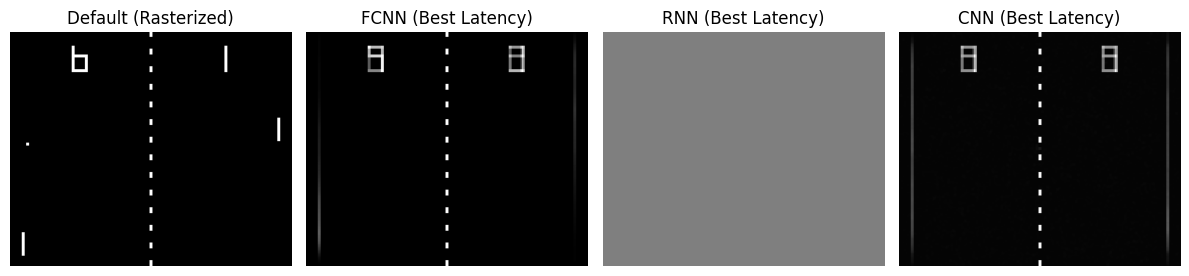

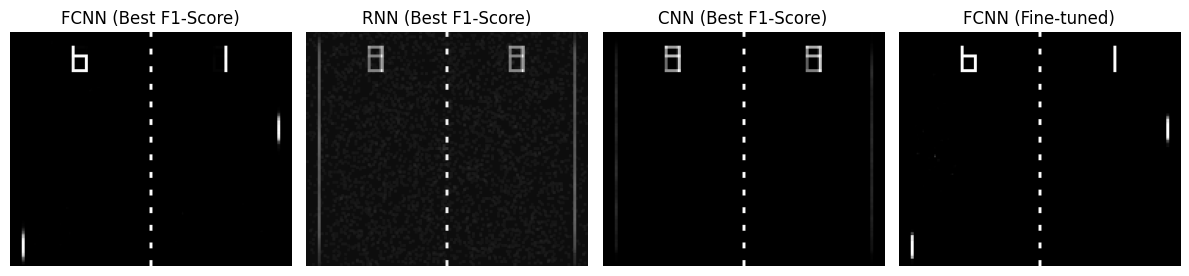



|                              Comparison Image Set #2                               |



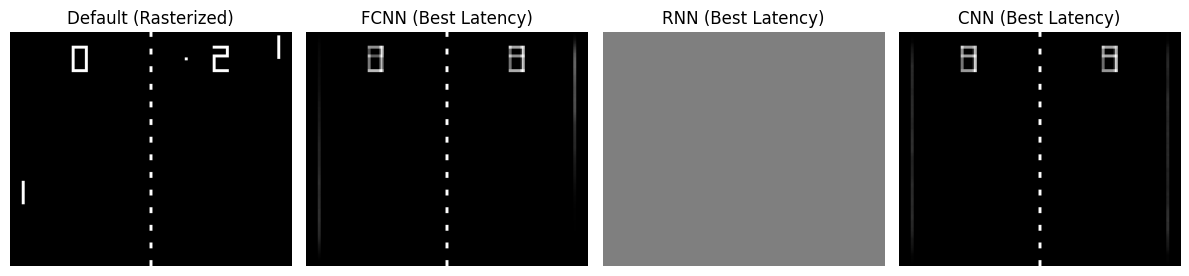

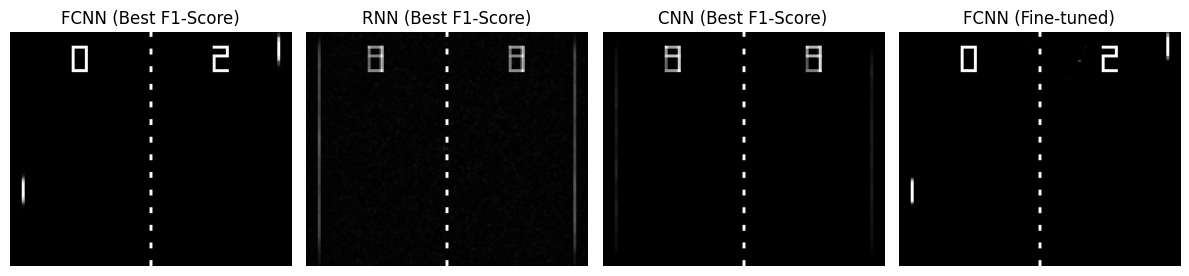

In [22]:
generate_comparison_images(2, seed=57)

#### DeepPong: Final Results

Here is where you can test out the final game with all the different renderers.

In [ ]:
import traceback


try:
    main()
except Exception as e:
    traceback.print_exc()